In [682]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations

from google.colab import data_table
from vega_datasets import data

from google.colab import files

!pip install pandas_bokeh

import pandas_bokeh
from bokeh.embed import components
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure, show


#pandas_bokeh.output_notebook()

# **I. Read-in the data and rename the columns.**



In [683]:
# Read-in LA-DOT API datasets and rename the column headers.

current = pd.read_csv('current.csv', names=['DateTime', 'Current'])
voltage = pd.read_csv('voltage.csv', names=['DateTime', 'Voltage'])
power = pd.read_csv('power.csv', names=['DateTime', 'Power'])
speed = pd.read_csv('speed.csv', names=['DateTime', 'Speed'])
gps = pd.read_csv('gps.csv', names=['DateTime', 'GPS'])
odo = pd.read_csv('odo.csv', names=['DateTime', 'Odometer'])

In [684]:
# Read-in GPS dataset with elevation info.

gps1 = pd.read_csv('gps1_elev.txt', sep='\s+')
gps2 = pd.read_csv('gps2_elev.txt', sep='\s+')
gps3 = pd.read_csv('gps3_elev.txt', sep='\s+')
gps4 = pd.read_csv('gps4_elev.txt', sep='\s+')
gps5 = pd.read_csv('gps5_elev.txt', sep='\s+')
gps6 = pd.read_csv('gps6_elev.txt', sep='\s+')
gps7 = pd.read_csv('gps7_elev.txt', sep='\s+')


In [685]:
# Create dataframe with just the elevation feature, excluding other header information.

gps1_e = gps1['altitude']
gps2_e = gps2['altitude']
gps3_e = gps3['altitude']
gps4_e = gps4['altitude']
gps5_e = gps5['altitude']
gps6_e = gps6['altitude']
gps7_e = gps7['altitude']


In [686]:
# Concatenate all the GPS+elevation dataset chunks into one dataframe.

gps_subsets = [gps1_e, gps2_e, gps3_e, gps4_e, gps5_e, gps6_e, gps7_e]

gps_concat = pd.concat(gps_subsets, ignore_index=True)


In [687]:
# Concatenate elevation dataset horizontally(axis=1) with the original LA-DOT GPS dataset to align them.
 
gps_concat_elev = pd.concat([gps, gps_concat], axis=1)

In [688]:
# Just a minor name change from 'altitude' to 'elevation' to reflect that it is a measure of elevation.
# Object vs Place.

gps_concat_elev.rename(columns = {'altitude':'Elevation'}, inplace = True)

In [689]:
# Delete GPS column.

elev = gps_concat_elev.drop('GPS', axis=1)

In [690]:
# Read-in climate/temperature dataset.

temp = pd.read_csv('la_climate_aug.csv', header = 0, usecols=['DATE', 'HourlyDryBulbTemperature'])

In [691]:
# Rename column names to our working names.

temp.rename(columns = {'DATE':'DateTime', 'HourlyDryBulbTemperature':'Temperature'}, inplace = True)

# **Note:** 
***Check duplicates before converting date-time feature into pandas Timestamp object, and eventually into DatetimeIndex object.***

*   Decide on the resolution for time. Retaining milliseconds will most likely return false for duplicates. Rounding down to seconds will increase the probability of returning true for duplicates. We want to identify and drop duplicates.
*   But in order to drop milliseconds, we have to convert date-time feature into pandas timestamp object.

*   After converting date-time to Timestamp object, drop the millisecond resolution.
*   Check for duplicate Timestamps.
*   Drop duplicates.
*   Now we can convert it into DatetimeIndex object.
*   This will enable some useful features such as resampling/up-sampling if we decide to. ***(you can only resample on DatetimeIndex objects, not Timestamp object)***.

*   asfreq() is for timeseries index only or dateTimeIndex object. In other words, it works only for index objects and not Timestamp object.

In [692]:
# Convert date-time("DateTime") into pd.timestamp object.

def convert_to_dateTimeObj(*dataframe):
  for x in dataframe:
    x['DateTime'] = pd.to_datetime(x['DateTime'])

convert_to_dateTimeObj(current, voltage, power, speed, elev, odo, temp)

In [693]:
# Count the number of duplicates in 'DateTime' timestamps in the datasets.

# Giving names to dataframes for convenience for the following function use.
voltage.name = 'Voltage'
current.name = 'Current'
power.name = 'Power'
speed.name = 'Speed'
elev.name = 'Elevation'
odo.name = 'Odometer'
temp.name = 'Temperature'

def count_duplicates(*dataframe):
  for x in dataframe:
    print(x.name, "has", x.duplicated(subset='DateTime').sum(), "duplicate timestamps.", '\n')

count_duplicates(current, voltage, power, speed, elev, odo, temp)

Current has 0 duplicate timestamps. 

Voltage has 0 duplicate timestamps. 

Power has 0 duplicate timestamps. 

Speed has 0 duplicate timestamps. 

Elevation has 0 duplicate timestamps. 

Odometer has 0 duplicate timestamps. 

Temperature has 1 duplicate timestamps. 



# **II. Count the number of NaNs in each dataframe.**

In [694]:
def count_NaNs(*dataframe):
  for x in dataframe:
    print("Count of NaNs for " + x.columns[1] + "-" + x.columns[0] + ": ", x.iloc[:, 0].isnull().sum())
    print("Count of NaNs for " + x.columns[1] + "-" + x.columns[1] + ": ", x.iloc[:, 1].isnull().sum())
    #if x.columns[2]:
      #print("Count of NaNs for " + x.columns[1] + "-" + x.columns[2] + ": ", x.iloc[:, 2].isnull().sum())
    print('\n')

count_NaNs(current, voltage, power, speed, elev, odo, temp)

Count of NaNs for Current-DateTime:  0
Count of NaNs for Current-Current:  0


Count of NaNs for Voltage-DateTime:  0
Count of NaNs for Voltage-Voltage:  0


Count of NaNs for Power-DateTime:  0
Count of NaNs for Power-Power:  0


Count of NaNs for Speed-DateTime:  0
Count of NaNs for Speed-Speed:  0


Count of NaNs for Elevation-DateTime:  0
Count of NaNs for Elevation-Elevation:  0


Count of NaNs for Odometer-DateTime:  0
Count of NaNs for Odometer-Odometer:  0


Count of NaNs for Temperature-DateTime:  0
Count of NaNs for Temperature-Temperature:  32




# **III. Get the 'shape' (row, column) of each dataframe.**

In [695]:
def print_shape(*dataframe):
  for x in dataframe:
    print(x.columns[1], 'shape: ', x.shape)

print_shape(current, voltage, power, speed, elev, odo, temp)

Current shape:  (742082, 2)
Voltage shape:  (258381, 2)
Power shape:  (742000, 2)
Speed shape:  (289669, 2)
Elevation shape:  (624301, 2)
Odometer shape:  (42118, 2)
Temperature shape:  (853, 2)


# **IV. Get the date-time range of each dataframe.**


In [696]:
def get_datetime_range(*dataframe):
  for x in dataframe:
    print(x.columns[1], 'minimum date: ', x.DateTime.min())
    print(x.columns[1], 'maximum date: ', x.DateTime.max())
    print(x.columns[1], 'date range: ', x.DateTime.max() - x.DateTime.min(), '\n')

get_datetime_range(current, voltage, power, speed, elev, odo, temp)

Current minimum date:  2020-08-01 12:09:44.499000
Current maximum date:  2020-08-30 12:59:59.645000
Current date range:  29 days 00:50:15.146000 

Voltage minimum date:  2020-08-01 12:09:44.499000
Voltage maximum date:  2020-08-30 12:57:19.642000
Voltage date range:  29 days 00:47:35.143000 

Power minimum date:  2020-08-01 12:09:44.499000
Power maximum date:  2020-08-30 12:59:59.645000
Power date range:  29 days 00:50:15.146000 

Speed minimum date:  2020-08-01 12:20:28.183000
Speed maximum date:  2020-08-30 12:54:22.646000
Speed date range:  29 days 00:33:54.463000 

Elevation minimum date:  2020-08-01 12:07:42.929000
Elevation maximum date:  2020-08-30 12:59:58.734000
Elevation date range:  29 days 00:52:15.805000 

Odometer minimum date:  2020-08-01 12:22:08.677000
Odometer maximum date:  2020-08-30 12:54:18.392000
Odometer date range:  29 days 00:32:09.715000 

Temperature minimum date:  2020-08-01 00:52:00
Temperature maximum date:  2020-08-31 23:59:00
Temperature date range:  30

# **V. Get the average time interval for each dataframe.**

In [697]:
"""
For reference:

Current shape:  (742082, 2)
Voltage shape:  (258381, 2)
Power shape:  (742000, 2)
Speed shape:  (289669, 2)
Elevation shape:  (624301, 2)
Odometer shape:  (42118, 2)
Temperature shape:  (853, 2)
"""

def time_interval(dataframe, num_of_rows):
  date_range = dataframe.DateTime.max() - dataframe.DateTime.min()
  interval = date_range/num_of_rows

  return interval


print("Current dataset average time interval: ", time_interval(current, 742082))
print("Voltage dataset average time interval: ", time_interval(voltage, 258381))
print("Power dataset average time interval: ", time_interval(power, 742000))
print("Speed dataset average time interval: ", time_interval(speed, 289669))
print("Elevation dataset average time interval: ", time_interval(elev, 624301))
print("Odometer dataset average time interval: ", time_interval(odo, 42118))
print("Temperature dataset average time interval: ", time_interval(temp, 853))

Current dataset average time interval:  0 days 00:00:03.380509358
Voltage dataset average time interval:  0 days 00:00:09.708357592
Power dataset average time interval:  0 days 00:00:03.380882946
Speed dataset average time interval:  0 days 00:00:08.656896191
Elevation dataset average time interval:  0 days 00:00:04.018471546
Odometer dataset average time interval:  0 days 00:00:59.535821145
Temperature dataset average time interval:  0 days 00:52:16.248534583


# **VI. Count how many timestamps match among each dataframe.**


In [698]:
from itertools import combinations

all_dataSets = [current, voltage, power, speed, elev, odo, temp]

comb = combinations(all_dataSets, 2)
for i,j in comb:
  count = i['DateTime'].isin(j['DateTime']).sum()
  print(i.columns[1], ' matches ', j.columns[1], count, ' times.')


Current  matches  Voltage 257915  times.
Current  matches  Power 741729  times.
Current  matches  Speed 0  times.
Current  matches  Elevation 416  times.
Current  matches  Odometer 0  times.
Current  matches  Temperature 1  times.
Voltage  matches  Power 257831  times.
Voltage  matches  Speed 0  times.
Voltage  matches  Elevation 231  times.
Voltage  matches  Odometer 0  times.
Voltage  matches  Temperature 1  times.
Power  matches  Speed 0  times.
Power  matches  Elevation 416  times.
Power  matches  Odometer 0  times.
Power  matches  Temperature 1  times.
Speed  matches  Elevation 293  times.
Speed  matches  Odometer 16  times.
Speed  matches  Temperature 0  times.
Elevation  matches  Odometer 21  times.
Elevation  matches  Temperature 1  times.
Odometer  matches  Temperature 0  times.


In [699]:
'''
index = ['Current', 'Voltage', 'Power', 'Speed', 'Elevation', 'Odometer']
columns = ['Voltage', 'Power', 'Speed', 'Elevation', 'Odometer', 'Temperature']
data = [257915, 741729, 0, 416, 0, 1, 257831, 0, 231, 0, 1, 0, 416, 0, 1, 293, 16, 0, 21, 1, 0]

match_matrix = pd.DataFrame(data, index=index, columns=columns)
'''

"\nindex = ['Current', 'Voltage', 'Power', 'Speed', 'Elevation', 'Odometer']\ncolumns = ['Voltage', 'Power', 'Speed', 'Elevation', 'Odometer', 'Temperature']\ndata = [257915, 741729, 0, 416, 0, 1, 257831, 0, 231, 0, 1, 0, 416, 0, 1, 293, 16, 0, 21, 1, 0]\n\nmatch_matrix = pd.DataFrame(data, index=index, columns=columns)\n"

In [700]:
# Count duplicated timestamps.
c_dup = current.duplicated(subset='DateTime').sum()
v_dup = voltage.duplicated(subset='DateTime').sum()
p_dup = power.duplicated(subset='DateTime').sum()
s_dup = speed.duplicated(subset='DateTime').sum()
e_dup = elev.duplicated(subset='DateTime').sum()
o_dup = odo.duplicated(subset='DateTime').sum()
t_dup = temp.duplicated(subset='DateTime').sum()

# Count number of NaNs.
c_null = current.isnull().sum()
v_null = voltage.isnull().sum()
p_null = power.isnull().sum()
s_null = speed.isnull().sum()
e_null = elev.isnull().sum()
o_null = odo.isnull().sum()
t_null = temp.isnull().sum()

# Shape.
c_shape = current.shape
v_shape = voltage.shape
p_shape = power.shape
s_shape = speed.shape
e_shape = elev.shape
o_shape = odo.shape
t_shape = temp.shape

# Min date.
c_min = current.DateTime.min()
v_min = voltage.DateTime.min()
p_min = power.DateTime.min()
s_min = speed.DateTime.min()
e_min = elev.DateTime.min()
o_min = odo.DateTime.min()
t_min = temp.DateTime.min()

# Max date.
c_max = current.DateTime.max()
v_max = voltage.DateTime.max()
p_max = power.DateTime.max()
s_max = speed.DateTime.max()
e_max = elev.DateTime.max()
o_max = odo.DateTime.max()
t_max = temp.DateTime.max()

# Date range.
c_range = c_max-c_min
v_range = v_max-v_min
p_range = p_max-p_min
s_range = s_max-s_min
e_range = e_max-e_min
o_range = o_max-o_min
t_range = t_max-t_min

"""
For reference:

Current shape:  (742082, 2)
Voltage shape:  (258381, 2)
Power shape:  (742000, 2)
Speed shape:  (289669, 2)
Elevation shape:  (624301, 2)
Odometer shape:  (42118, 2)
Temperature shape:  (853, 2)
"""

# Time interval.
c_time_int = c_range/742082
v_time_int = v_range/258381
p_time_int = p_range/742000
s_time_int = s_range/289669
e_time_int = e_range/624301
o_time_int = o_range/42118
t_time_int = t_range/853

# Table of dataset summary.
d = {
    'Count Duplicated Timestamp': [c_dup, v_dup, p_dup, s_dup, e_dup, o_dup, t_dup],
     'Count NaNs': [c_null, v_null, p_null, s_null, e_null, o_null, t_null],
     'Shape(row column)': [c_shape, v_shape, p_shape, s_shape, e_shape, o_shape, t_shape],
     'Min. Date': [c_min, v_min, p_min, s_min, e_min, o_min, t_min],
     'Max. Date': [c_max, v_max, p_max, s_max, e_max, o_max, t_max],
     'Date Range': [c_range, v_range, p_range, s_range, e_range, o_range, t_range],
     'Avg. Time Interval': [c_time_int, v_time_int, p_time_int, s_time_int, e_time_int, o_time_int, t_time_int]
}

summary_table = pd.DataFrame(d, index=['Current', 'Voltage', 'Power', 'Speed', 'Elevation', 'Odometer', 'Temperature'])

In [701]:
summary_table

,Count Duplicated Timestamp,Count NaNs,Shape(row column),Min. Date,Max. Date,Date Range,Avg. Time Interval
Current,0,DateTime 0 Current 0 dtype: int64,"(742082, 2)",2020-08-01 12:09:44.499,2020-08-30 12:59:59.645,29 days 00:50:15.146000,0 days 00:00:03.380509358
Voltage,0,DateTime 0 Voltage 0 dtype: int64,"(258381, 2)",2020-08-01 12:09:44.499,2020-08-30 12:57:19.642,29 days 00:47:35.143000,0 days 00:00:09.708357592
Power,0,DateTime 0 Power 0 dtype: int64,"(742000, 2)",2020-08-01 12:09:44.499,2020-08-30 12:59:59.645,29 days 00:50:15.146000,0 days 00:00:03.380882946
Speed,0,DateTime 0 Speed 0 dtype: int64,"(289669, 2)",2020-08-01 12:20:28.183,2020-08-30 12:54:22.646,29 days 00:33:54.463000,0 days 00:00:08.656896191
Elevation,0,DateTime 0 Elevation 0 dtype: int64,"(624301, 2)",2020-08-01 12:07:42.929,2020-08-30 12:59:58.734,29 days 00:52:15.805000,0 days 00:00:04.018471546
Odometer,0,DateTime 0 Odometer 0 dtype: int64,"(42118, 2)",2020-08-01 12:22:08.677,2020-08-30 12:54:18.392,29 days 00:32:09.715000,0 days 00:00:59.535821145
Temperature,1,DateTime 0 Temperature 32 dtype: int64,"(853, 2)",2020-08-01 00:52:00.000,2020-08-31 23:59:00.000,30 days 23:07:00,0 days 00:52:16.248534583


In [702]:
# Output table to html for website.

html = summary_table.to_html()

# Write html to file
file = open("summary_table.html", "w")
file.write(html)
file.close()

In [703]:
# Decrease the resolution of time by dropping millisecond.

def drop_ms(*dataframe):
  for x in dataframe:
    x['DateTime'] = x['DateTime'].round('S')

drop_ms(current, voltage, power, speed, elev, odo, temp)

In [704]:
# Fill-in temperature NaNs using linear interpolcation.

temp.interpolate(method='linear', inplace=True)

In [705]:
# After millisecond drop and filling-in NaNs of temperature.

# Count duplicated timestamps.
c_dup_d = current.duplicated(subset='DateTime').sum()
v_dup_d = voltage.duplicated(subset='DateTime').sum()
p_dup_d = power.duplicated(subset='DateTime').sum()
s_dup_d = speed.duplicated(subset='DateTime').sum()
e_dup_d = elev.duplicated(subset='DateTime').sum()
o_dup_d = odo.duplicated(subset='DateTime').sum()
t_dup_d = temp.duplicated(subset='DateTime').sum()

# Count number of NaNs.
c_null_d = current.isnull().sum()
v_null_d = voltage.isnull().sum()
p_null_d = power.isnull().sum()
s_null_d = speed.isnull().sum()
e_null_d = elev.isnull().sum()
o_null_d = odo.isnull().sum()
t_null_d = temp.isnull().sum()

# Shape.
c_shape_d = current.shape
v_shape_d = voltage.shape
p_shape_d = power.shape
s_shape_d = speed.shape
e_shape_d = elev.shape
o_shape_d = odo.shape
t_shape_d = temp.shape

# Min date.
c_min_d = current.DateTime.min()
v_min_d = voltage.DateTime.min()
p_min_d = power.DateTime.min()
s_min_d = speed.DateTime.min()
e_min_d = elev.DateTime.min()
o_min_d = odo.DateTime.min()
t_min_d = temp.DateTime.min()

# Max date.
c_max_d = current.DateTime.max()
v_max_d = voltage.DateTime.max()
p_max_d = power.DateTime.max()
s_max_d = speed.DateTime.max()
e_max_d = elev.DateTime.max()
o_max_d = odo.DateTime.max()
t_max_d = temp.DateTime.max()

# Date range.
c_range_d = c_max_d-c_min_d
v_range_d = v_max_d-v_min_d
p_range_d = p_max_d-p_min_d
s_range_d = s_max_d-s_min_d
e_range_d = e_max_d-e_min_d
o_range_d = o_max_d-o_min_d
t_range_d = t_max_d-t_min_d

"""
For reference:

Current shape:  (742082, 2)
Voltage shape:  (258381, 2)
Power shape:  (742000, 2)
Speed shape:  (289669, 2)
Elevation shape:  (624301, 2)
Odometer shape:  (42118, 2)
Temperature shape:  (853, 2)
"""

# Time interval.
c_time_int_d = c_range_d/742082
v_time_int_d = v_range_d/258381
p_time_int_d = p_range_d/742000
s_time_int_d = s_range_d/289669
e_time_int_d = e_range_d/624301
o_time_int_d = o_range_d/42118
t_time_int_d = t_range_d/853

# Table of dataset summary.
d_d = {
    'Count Duplicated Timestamp': [c_dup_d, v_dup_d, p_dup_d, s_dup_d, e_dup_d, o_dup_d, t_dup_d],
     'Count NaNs': [c_null_d, v_null_d, p_null_d, s_null_d, e_null_d, o_null_d, t_null_d],
     'Shape(row column)': [c_shape_d, v_shape_d, p_shape_d, s_shape_d, e_shape_d, o_shape_d, t_shape_d],
     'Min. Date': [c_min_d, v_min_d, p_min_d, s_min_d, e_min_d, o_min_d, t_min_d],
     'Max. Date': [c_max_d, v_max_d, p_max_d, s_max_d, e_max_d, o_max_d, t_max_d],
     'Date Range': [c_range_d, v_range_d, p_range_d, s_range_d, e_range_d, o_range_d, t_range_d],
     'Avg. Time Interval': [c_time_int_d, v_time_int_d, p_time_int_d, s_time_int_d, e_time_int_d, o_time_int_d, t_time_int_d]
}

summary_table_afterdrop = pd.DataFrame(d_d, index=['Current', 'Voltage', 'Power', 'Speed', 'Elevation', 'Odometer', 'Temperature'])

In [706]:
summary_table_afterdrop

,Count Duplicated Timestamp,Count NaNs,Shape(row column),Min. Date,Max. Date,Date Range,Avg. Time Interval
Current,541,DateTime 0 Current 0 dtype: int64,"(742082, 2)",2020-08-01 12:09:44,2020-08-30 13:00:00,29 days 00:50:16,0 days 00:00:03.380510509
Voltage,227,DateTime 0 Voltage 0 dtype: int64,"(258381, 2)",2020-08-01 12:09:44,2020-08-30 12:57:20,29 days 00:47:36,0 days 00:00:09.708360908
Power,461,DateTime 0 Power 0 dtype: int64,"(742000, 2)",2020-08-01 12:09:44,2020-08-30 13:00:00,29 days 00:50:16,0 days 00:00:03.380884097
Speed,128,DateTime 0 Speed 0 dtype: int64,"(289669, 2)",2020-08-01 12:20:28,2020-08-30 12:54:23,29 days 00:33:55,0 days 00:00:08.656898045
Elevation,1,DateTime 0 Elevation 0 dtype: int64,"(624301, 2)",2020-08-01 12:07:43,2020-08-30 12:59:59,29 days 00:52:16,0 days 00:00:04.018471858
Odometer,7,DateTime 0 Odometer 0 dtype: int64,"(42118, 2)",2020-08-01 12:22:09,2020-08-30 12:54:18,29 days 00:32:09,0 days 00:00:59.535804169
Temperature,1,DateTime 0 Temperature 0 dtype: int64,"(853, 2)",2020-08-01 00:52:00,2020-08-31 23:59:00,30 days 23:07:00,0 days 00:52:16.248534583


In [707]:
# Output tabel to html for website.

html = summary_table_afterdrop.to_html()

# Write html to file
file = open("summary_table_afterdrop.html", "w")
file.write(html)
file.close()

In [708]:
# Count matching timestamps among the datasets after dropping milliseconds.

from itertools import combinations

all_dataSets = [current, voltage, power, speed, elev, odo, temp]

comb = combinations(all_dataSets, 2)
for i,j in comb:
  count = i['DateTime'].isin(j['DateTime']).sum()
  print(i.columns[1], ' matches ', j.columns[1], count, ' times.')

Current  matches  Voltage 257996  times.
Current  matches  Power 741810  times.
Current  matches  Speed 288070  times.
Current  matches  Elevation 422461  times.
Current  matches  Odometer 41987  times.
Current  matches  Temperature 227  times.
Voltage  matches  Power 257926  times.
Voltage  matches  Speed 200240  times.
Voltage  matches  Elevation 229165  times.
Voltage  matches  Odometer 30535  times.
Voltage  matches  Temperature 82  times.
Power  matches  Speed 288017  times.
Power  matches  Elevation 422401  times.
Power  matches  Odometer 41976  times.
Power  matches  Temperature 227  times.
Speed  matches  Elevation 272538  times.
Speed  matches  Odometer 33487  times.
Speed  matches  Temperature 89  times.
Elevation  matches  Odometer 41221  times.
Elevation  matches  Temperature 186  times.
Odometer  matches  Temperature 15  times.


In [709]:
# Drop dupicates from each dataset.

def my_drop_duplicates(*dataframe):
  for x in dataframe:
    x.drop_duplicates(subset='DateTime', inplace=True)

my_drop_duplicates(current, voltage, power, speed, elev, odo, temp)



In [710]:
# Count matching timestamps among the datasets AFTER dropping the duplicates.

from itertools import combinations

all_dataSets = [current, voltage, power, speed, elev, odo, temp]

comb = combinations(all_dataSets, 2)
for i,j in comb:
  count = i['DateTime'].isin(j['DateTime']).sum()
  print(i.columns[1], ' matches ', j.columns[1], count, ' times.')

Current  matches  Voltage 257707  times.
Current  matches  Power 741272  times.
Current  matches  Speed 287872  times.
Current  matches  Elevation 422164  times.
Current  matches  Odometer 41958  times.
Current  matches  Temperature 227  times.
Voltage  matches  Power 257702  times.
Voltage  matches  Speed 200132  times.
Voltage  matches  Elevation 229026  times.
Voltage  matches  Odometer 30519  times.
Voltage  matches  Temperature 82  times.
Power  matches  Speed 287819  times.
Power  matches  Elevation 422119  times.
Power  matches  Odometer 41947  times.
Power  matches  Temperature 227  times.
Speed  matches  Elevation 272418  times.
Speed  matches  Odometer 33470  times.
Speed  matches  Temperature 88  times.
Elevation  matches  Odometer 41221  times.
Elevation  matches  Temperature 186  times.
Odometer  matches  Temperature 15  times.


In [711]:
# TODO: code for combinatoric matrix for above output.

'''
#combo_count = pd.DataFrame()
for i,j in comb:
  count = i['DateTime'].isin(j['DateTime']).sum()
  #print(i.columns[1], ' matches ', j.columns[1], count, ' times.')
  index+=([i.columns[1]])
  column+=([j.columns[1]])
  combo_count = pd.DataFrame.from_records(index=index, columns=column, data=count)
'''

  

"\n#combo_count = pd.DataFrame()\nfor i,j in comb:\n  count = i['DateTime'].isin(j['DateTime']).sum()\n  #print(i.columns[1], ' matches ', j.columns[1], count, ' times.')\n  index+=([i.columns[1]])\n  column+=([j.columns[1]])\n  combo_count = pd.DataFrame.from_records(index=index, columns=column, data=count)\n"


# **End Stage 1. Preliminary evaluation.**
---



# **VII. Merge.**

In [712]:
"""Preview of merge before and after dropping duplicates."""

""" Before dropping duplicates.
Current  matches  Voltage 257996  times.
Current  matches  Power 741810  times.
Current  matches  Speed 288070  times.
Current  matches  Elevation 422461  times.
Current  matches  Odometer 41987  times.
Current  matches  Temperature 227  times.
Voltage  matches  Power 257926  times.
Voltage  matches  Speed 200240  times.
Voltage  matches  Elevation 229165  times.
Voltage  matches  Odometer 30535  times.
Voltage  matches  Temperature 82  times.
Power  matches  Speed 288017  times.
Power  matches  Elevation 422401  times.
Power  matches  Odometer 41976  times.
Power  matches  Temperature 227  times.
Speed  matches  Elevation 272538  times.
Speed  matches  Odometer 33487  times.
Speed  matches  Temperature 89  times.
Elevation  matches  Odometer 41221  times.
Elevation  matches  Temperature 186  times.
Odometer  matches  Temperature 15  times.
"""

"""After dropping duplicates.
Current  matches  Voltage 257707  times.
Current  matches  Power 741272  times.
Current  matches  Speed 287872  times.
Current  matches  Elevation 422164  times.
Current  matches  Odometer 41958  times.
Current  matches  Temperature 227  times.
Voltage  matches  Power 257702  times.
Voltage  matches  Speed 200132  times.
Voltage  matches  Elevation 229026  times.
Voltage  matches  Odometer 30519  times.
Voltage  matches  Temperature 82  times.
Power  matches  Speed 287819  times.
Power  matches  Elevation 422119  times.
Power  matches  Odometer 41947  times.
Power  matches  Temperature 227  times.
Speed  matches  Elevation 272418  times.
Speed  matches  Odometer 33470  times.
Speed  matches  Temperature 88  times.
Elevation  matches  Odometer 41221  times.
Elevation  matches  Temperature 186  times.
Odometer  matches  Temperature 15  times.
"""

#cp = pd.merge(current, power, left_index=True, right_index=True)
cp = pd.merge(current, power, on='DateTime')

In [713]:
#cpv = pd.merge(cp, voltage, left_index=True, right_index=True)
cpv = pd.merge(cp, voltage, on='DateTime')

In [714]:
#cpve = pd.merge(cpv, elev, left_index=True, right_index=True)
cpve = pd.merge(cpv, elev, on='DateTime')

In [715]:
cpve

,DateTime,Current,Power,Voltage,Elevation
0,2020-08-01 12:10:15,8.3,4.3575,525,68.5
1,2020-08-01 12:10:16,8.3,4.3492,524,68.4
2,2020-08-01 12:10:47,9.7,5.0828,524,68.7
3,2020-08-01 12:10:48,9.5,4.9685,523,68.7
4,2020-08-01 12:11:41,9.5,4.9685,523,68.7
...,...,...,...,...,...
228828,2020-08-30 12:56:56,3.2,1.6512,516,34.3
228829,2020-08-30 12:56:57,3.2,1.6480,515,34.3
228830,2020-08-30 12:56:59,3.2,1.6480,515,34.3
228831,2020-08-30 12:57:00,3.1,1.5996,516,34.3


In [716]:
#cpves = pd.merge(cpve, speed, left_index=True, right_index=True)
cpves = pd.merge(cpve, speed, on='DateTime')

In [717]:
cpves

,DateTime,Current,Power,Voltage,Elevation,Speed
0,2020-08-01 12:20:30,15.8,8.1686,517,68.7,1
1,2020-08-01 12:20:36,22.1,11.4036,516,68.6,6
2,2020-08-01 12:20:37,-3.3,-1.7061,517,68.6,5
3,2020-08-01 12:22:04,49.4,25.4904,516,68.5,6
4,2020-08-01 12:22:10,25.8,13.2870,515,68.5,11
...,...,...,...,...,...,...
190119,2020-08-30 12:54:10,-81.8,-42.1270,515,34.3,15
190120,2020-08-30 12:54:11,-58.7,-30.2892,516,34.3,11
190121,2020-08-30 12:54:12,0.2,0.1030,515,34.3,10
190122,2020-08-30 12:54:15,-34.8,-17.9220,515,34.3,9


In [718]:
#cpveso = pd.merge(cpves, odo, left_index=True, right_index=True, how='left').interpolate(method='linear', limit_direction='both')
cpveso = pd.merge(cpves, odo, on='DateTime', how='left').interpolate(method='linear', limit_direction='both')

In [719]:
cpveso

,DateTime,Current,Power,Voltage,Elevation,Speed,Odometer
0,2020-08-01 12:20:30,15.8,8.1686,517,68.7,1,136973.7
1,2020-08-01 12:20:36,22.1,11.4036,516,68.6,6,136973.7
2,2020-08-01 12:20:37,-3.3,-1.7061,517,68.6,5,136973.7
3,2020-08-01 12:22:04,49.4,25.4904,516,68.5,6,136973.7
4,2020-08-01 12:22:10,25.8,13.2870,515,68.5,11,136973.7
...,...,...,...,...,...,...,...
190119,2020-08-30 12:54:10,-81.8,-42.1270,515,34.3,15,139132.3
190120,2020-08-30 12:54:11,-58.7,-30.2892,516,34.3,11,139132.3
190121,2020-08-30 12:54:12,0.2,0.1030,515,34.3,10,139132.3
190122,2020-08-30 12:54:15,-34.8,-17.9220,515,34.3,9,139132.3


In [720]:
#cpvesot= pd.merge(cpveso, temp, left_index=True, right_index=True, how='left').interpolate(method='time', limit_direction='both')
cpvesot= pd.merge(cpveso, temp, on='DateTime', how='left').interpolate(method='linear', limit_direction='both')

In [721]:
cpvesot

,DateTime,Current,Power,Voltage,Elevation,Speed,Odometer,Temperature
0,2020-08-01 12:20:30,15.8,8.1686,517,68.7,1,136973.7,87.0
1,2020-08-01 12:20:36,22.1,11.4036,516,68.6,6,136973.7,87.0
2,2020-08-01 12:20:37,-3.3,-1.7061,517,68.6,5,136973.7,87.0
3,2020-08-01 12:22:04,49.4,25.4904,516,68.5,6,136973.7,87.0
4,2020-08-01 12:22:10,25.8,13.2870,515,68.5,11,136973.7,87.0
...,...,...,...,...,...,...,...,...
190119,2020-08-30 12:54:10,-81.8,-42.1270,515,34.3,15,139132.3,75.0
190120,2020-08-30 12:54:11,-58.7,-30.2892,516,34.3,11,139132.3,75.0
190121,2020-08-30 12:54:12,0.2,0.1030,515,34.3,10,139132.3,75.0
190122,2020-08-30 12:54:15,-34.8,-17.9220,515,34.3,9,139132.3,75.0


In [722]:
# v_line = august_threeToseven.plot_bokeh(kind='line', title='Voltage 8/3-8/7', x='Voltage', y='Current', xlabel='Date-Time', ylabel='Voltage', rangetool=True)

In [723]:
# Just reordering the columns.

#cpvesot=cpvesot[['Current', 'Voltage', 'Power', 'Elevation', 'Speed', 'Odometer', 'Temperature']]
cpvesot=cpvesot[['DateTime', 'Current', 'Voltage', 'Power', 'Elevation', 'Speed', 'Odometer', 'Temperature']]

In [724]:
# Group by day of the month.

#grouped = cpvesot.groupby(cpvesot.index.date)
grouped = cpvesot.groupby(pd.Grouper(key='DateTime', axis=0, freq='D'))


In [725]:
# Create dataframe from group to count number of values from feature.

count_ofactivity = grouped.count()

In [726]:
count_ofactivity

,Current,Voltage,Power,Elevation,Speed,Odometer,Temperature
DateTime,,,,,,,
2020-08-01,9534,9534,9534,9534,9534,9534,9534
2020-08-02,0,0,0,0,0,0,0
2020-08-03,12850,12850,12850,12850,12850,12850,12850
2020-08-04,12530,12530,12530,12530,12530,12530,12530
2020-08-05,12649,12649,12649,12649,12649,12649,12649
2020-08-06,13765,13765,13765,13765,13765,13765,13765
2020-08-07,14199,14199,14199,14199,14199,14199,14199
2020-08-08,8716,8716,8716,8716,8716,8716,8716
2020-08-09,0,0,0,0,0,0,0


In [727]:
# Output table to html for website.

html = count_ofactivity.to_html()

# Write html to file
file = open("count_ofactivity.html", "w")
file.write(html)
file.close()

In [728]:
#august_threeToseven = cpvesot.index['08-03':'08-07'] # Use when timestamp/datetime is an index or dateTimeIndex object.

# Create dataframe for dates 8/3 - 8/7.
august_threeToseven = cpvesot[(cpvesot['DateTime'] > '2020-08-02') & (cpvesot['DateTime'] < '2020-08-08')]

In [729]:
august_threeToseven

,DateTime,Current,Voltage,Power,Elevation,Speed,Odometer,Temperature
9534,2020-08-03 08:56:49,25.8,515,13.2870,68.7,11,137084.466667,75.486327
9535,2020-08-03 08:56:50,-5.2,516,-2.6832,68.7,9,137084.500000,75.491500
9536,2020-08-03 08:56:53,1.8,515,0.9270,68.7,7,137084.502564,75.496674
9537,2020-08-03 08:56:58,27.0,514,13.8780,68.7,9,137084.505128,75.501848
9538,2020-08-03 08:57:02,14.4,515,7.4160,68.6,8,137084.507692,75.507021
...,...,...,...,...,...,...,...,...
75522,2020-08-07 22:03:51,35.6,493,17.5508,68.5,10,137825.756522,73.441026
75523,2020-08-07 22:03:52,36.6,492,18.0072,68.5,11,137825.765217,73.446154
75524,2020-08-07 22:03:53,-29.2,494,-14.4248,68.5,9,137825.773913,73.451282
75525,2020-08-07 22:03:54,18.5,494,9.1390,68.5,8,137825.782609,73.456410


In [730]:
# For some reason, after merge and/or grouping, precision increased. Therefore we are rounding it down again here.

august_threeToseven['Temperature'] = august_threeToseven['Temperature'].round(decimals=0)
august_threeToseven['Odometer'] = august_threeToseven['Odometer'].round(decimals=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [731]:
# Output table to html for website.

html = august_threeToseven.to_html(max_rows=20)

# Write html to file
file = open("august_threeToseven.html", "w")
file.write(html)
file.close()


# **End Stage 2. Merged.**
---



# **VIII. Extrapolate 'Acceleration'.**

In [732]:
#speed = august_threeToseven['Speed'].diff()*0.2777777778
#seconds = august_threeToseven['DateTime'].diff().dt.total_seconds()
#acceleration = speed/seconds

# Km/h to m/s conversion to get acceleration as m/s.
august_threeToseven['Acceleration'] = ((august_threeToseven['Speed'].diff())*0.2777777778/(august_threeToseven['DateTime'].diff()).dt.total_seconds())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [733]:
august_threeToseven

,DateTime,Current,Voltage,Power,Elevation,Speed,Odometer,Temperature,Acceleration
9534,2020-08-03 08:56:49,25.8,515,13.2870,68.7,11,137084.5,75.0,NaN
9535,2020-08-03 08:56:50,-5.2,516,-2.6832,68.7,9,137084.5,75.0,-0.555556
9536,2020-08-03 08:56:53,1.8,515,0.9270,68.7,7,137084.5,75.0,-0.185185
9537,2020-08-03 08:56:58,27.0,514,13.8780,68.7,9,137084.5,76.0,0.111111
9538,2020-08-03 08:57:02,14.4,515,7.4160,68.6,8,137084.5,76.0,-0.069444
...,...,...,...,...,...,...,...,...,...
75522,2020-08-07 22:03:51,35.6,493,17.5508,68.5,10,137825.8,73.0,0.055556
75523,2020-08-07 22:03:52,36.6,492,18.0072,68.5,11,137825.8,73.0,0.277778
75524,2020-08-07 22:03:53,-29.2,494,-14.4248,68.5,9,137825.8,73.0,-0.555556
75525,2020-08-07 22:03:54,18.5,494,9.1390,68.5,8,137825.8,73.0,-0.277778


In [734]:
# Fill-in any NaNs from 'Acceleration' with 0.

august_threeToseven['Acceleration'] = august_threeToseven['Acceleration'].fillna(0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [735]:
august_threeToseven

,DateTime,Current,Voltage,Power,Elevation,Speed,Odometer,Temperature,Acceleration
9534,2020-08-03 08:56:49,25.8,515,13.2870,68.7,11,137084.5,75.0,0.000000
9535,2020-08-03 08:56:50,-5.2,516,-2.6832,68.7,9,137084.5,75.0,-0.555556
9536,2020-08-03 08:56:53,1.8,515,0.9270,68.7,7,137084.5,75.0,-0.185185
9537,2020-08-03 08:56:58,27.0,514,13.8780,68.7,9,137084.5,76.0,0.111111
9538,2020-08-03 08:57:02,14.4,515,7.4160,68.6,8,137084.5,76.0,-0.069444
...,...,...,...,...,...,...,...,...,...
75522,2020-08-07 22:03:51,35.6,493,17.5508,68.5,10,137825.8,73.0,0.055556
75523,2020-08-07 22:03:52,36.6,492,18.0072,68.5,11,137825.8,73.0,0.277778
75524,2020-08-07 22:03:53,-29.2,494,-14.4248,68.5,9,137825.8,73.0,-0.555556
75525,2020-08-07 22:03:54,18.5,494,9.1390,68.5,8,137825.8,73.0,-0.277778


In [736]:
august_threeToseven['Odometer'].iloc[0]

137084.5

In [737]:
# Output table to html for website.

html = august_threeToseven.to_html(max_rows=20)

# Write html to file
file = open("august_threeToseven_acc.html", "w")
file.write(html)
file.close()

# **End of Stage 3. Acceleration extrapolated.**

# **IX. Extrapolate Grade and Angle.**

In [738]:

#august_threeToseven['Elevation Change'] = august_threeToseven['Elevation'].diff()
#august_threeToseven['Odometer Change'] = august_threeToseven['Odometer'].diff()

In [739]:
#august_threeToseven['Grade'] = august_threeToseven['Elevation'][::100].diff()/((august_threeToseven['Odometer'][::100]*.3048).diff())

In [740]:
#august_threeToseven['Angle'] = np.arctan(august_threeToseven['Elevation'].diff()/(august_threeToseven['Odometer']*.3048).diff())

In [741]:
august_threeToseven['Grade'] = np.nan

'''
for i in range(len(august_threeToseven['Odometer']),1):
  for j in range(len(august_threeToseven['Odometer']),1):
    x = august_threeToseven['Odometer'][j] - august_threeToseven['Odometer'][i]
    if x == 1.0:
      august_threeToseven['Grade'][j] = (august_threeToseven['Elevation'][j] - august_threeToseven['Elevation'][i])/(august_threeToseven['Odometer'][j] - august_threeToseven['Odometer'][i])*.3048
      i=j
'''

i = len(august_threeToseven['Odometer'])

count_1 = 9534
count_2 = 9535

while count_2 < i:
    if (august_threeToseven['Odometer'][count_2] - august_threeToseven['Odometer'][count_1]) == .5:
      august_threeToseven['Grade'][count_2] = (august_threeToseven['Elevation'][count_2] - august_threeToseven['Elevation'][count_1])/(august_threeToseven['Odometer'][count_2] - august_threeToseven['Odometer'][count_1])*.3048
      count_1 = count_2

    count_2 += 1



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

In [742]:
august_threeToseven

,DateTime,Current,Voltage,Power,Elevation,Speed,Odometer,Temperature,Acceleration,Grade
9534,2020-08-03 08:56:49,25.8,515,13.2870,68.7,11,137084.5,75.0,0.000000,NaN
9535,2020-08-03 08:56:50,-5.2,516,-2.6832,68.7,9,137084.5,75.0,-0.555556,NaN
9536,2020-08-03 08:56:53,1.8,515,0.9270,68.7,7,137084.5,75.0,-0.185185,NaN
9537,2020-08-03 08:56:58,27.0,514,13.8780,68.7,9,137084.5,76.0,0.111111,NaN
9538,2020-08-03 08:57:02,14.4,515,7.4160,68.6,8,137084.5,76.0,-0.069444,NaN
...,...,...,...,...,...,...,...,...,...,...
75522,2020-08-07 22:03:51,35.6,493,17.5508,68.5,10,137825.8,73.0,0.055556,NaN
75523,2020-08-07 22:03:52,36.6,492,18.0072,68.5,11,137825.8,73.0,0.277778,NaN
75524,2020-08-07 22:03:53,-29.2,494,-14.4248,68.5,9,137825.8,73.0,-0.555556,NaN
75525,2020-08-07 22:03:54,18.5,494,9.1390,68.5,8,137825.8,73.0,-0.277778,NaN


In [743]:
august_threeToseven['Grade'].isnull().sum()

65350

In [744]:
august_threeToseven['Grade'].fillna(method='bfill', inplace=True)


/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [745]:
august_threeToseven['Grade'].fillna(method='ffill', inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [746]:
august_threeToseven['Angle'] = np.arctan(august_threeToseven['Elevation'].diff()/(august_threeToseven['Odometer']*.3048).diff())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [747]:
august_threeToseven['Angle'].fillna(method='bfill', inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [748]:
august_threeToseven['Angle'].fillna(method='ffill', inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [749]:
august_threeToseven

,DateTime,Current,Voltage,Power,Elevation,Speed,Odometer,Temperature,Acceleration,Grade,Angle
9534,2020-08-03 08:56:49,25.8,515,13.2870,68.7,11,137084.5,75.0,0.000000,0.48768,-1.570796
9535,2020-08-03 08:56:50,-5.2,516,-2.6832,68.7,9,137084.5,75.0,-0.555556,0.48768,-1.570796
9536,2020-08-03 08:56:53,1.8,515,0.9270,68.7,7,137084.5,75.0,-0.185185,0.48768,-1.570796
9537,2020-08-03 08:56:58,27.0,514,13.8780,68.7,9,137084.5,76.0,0.111111,0.48768,-1.570796
9538,2020-08-03 08:57:02,14.4,515,7.4160,68.6,8,137084.5,76.0,-0.069444,0.48768,-1.570796
...,...,...,...,...,...,...,...,...,...,...,...
75522,2020-08-07 22:03:51,35.6,493,17.5508,68.5,10,137825.8,73.0,0.055556,0.18288,-1.274942
75523,2020-08-07 22:03:52,36.6,492,18.0072,68.5,11,137825.8,73.0,0.277778,0.18288,-1.570796
75524,2020-08-07 22:03:53,-29.2,494,-14.4248,68.5,9,137825.8,73.0,-0.555556,0.18288,-1.570796
75525,2020-08-07 22:03:54,18.5,494,9.1390,68.5,8,137825.8,73.0,-0.277778,0.18288,-1.570796


# **X. Set the 'DateTime' column as an index to enable convenient DatetimeIndex object methods such as resampling.**

In [750]:
# Convert DateTime column into dateTimeIndex object.

'''
def my_convert_to_dateTimeIndex(*dataframe):
  for x in dataframe:
    x.set_index('DateTime', inplace=True)

my_convert_to_dateTimeIndex(current, voltage, power, speed, elev, odo, temp)
'''

august_threeToseven_i = august_threeToseven.set_index('DateTime')

In [751]:
august_threeToseven_i

,Current,Voltage,Power,Elevation,Speed,Odometer,Temperature,Acceleration,Grade,Angle
DateTime,,,,,,,,,,
2020-08-03 08:56:49,25.8,515,13.2870,68.7,11,137084.5,75.0,0.000000,0.48768,-1.570796
2020-08-03 08:56:50,-5.2,516,-2.6832,68.7,9,137084.5,75.0,-0.555556,0.48768,-1.570796
2020-08-03 08:56:53,1.8,515,0.9270,68.7,7,137084.5,75.0,-0.185185,0.48768,-1.570796
2020-08-03 08:56:58,27.0,514,13.8780,68.7,9,137084.5,76.0,0.111111,0.48768,-1.570796
2020-08-03 08:57:02,14.4,515,7.4160,68.6,8,137084.5,76.0,-0.069444,0.48768,-1.570796
...,...,...,...,...,...,...,...,...,...,...
2020-08-07 22:03:51,35.6,493,17.5508,68.5,10,137825.8,73.0,0.055556,0.18288,-1.274942
2020-08-07 22:03:52,36.6,492,18.0072,68.5,11,137825.8,73.0,0.277778,0.18288,-1.570796
2020-08-07 22:03:53,-29.2,494,-14.4248,68.5,9,137825.8,73.0,-0.555556,0.18288,-1.570796


In [752]:
august_threeToseven_i.isnull().sum()

Current         0
Voltage         0
Power           0
Elevation       0
Speed           0
Odometer        0
Temperature     0
Acceleration    0
Grade           0
Angle           0
dtype: int64

# **XI. Resample(downsample) timeseries down to hour and day and aggregate.**

In [753]:

august_threeToseven_i_byMin = august_threeToseven_i.resample('T', closed='right').mean()
august_threeToseven_i_byMin['DayofWeek'] = august_threeToseven_i_byMin.index.day_name()

august_threeToseven_i_byHour = august_threeToseven_i.resample('H', closed='right').mean()
august_threeToseven_i_byHour['DayofWeek'] = august_threeToseven_i_byHour.index.day_name()

august_threeToseven_i_byDay = august_threeToseven_i.resample('D', closed='right').mean()
august_threeToseven_i_byDay['DayofWeek'] = august_threeToseven_i_byDay.index.day_name()




In [754]:
august_threeToseven_i_byMin

,Current,Voltage,Power,Elevation,Speed,Odometer,Temperature,Acceleration,Grade,Angle,DayofWeek
DateTime,,,,,,,,,,,
2020-08-03 08:56:00,12.350000,515.000000,6.352200,68.700000,9.000000,137084.500000,75.25,-0.157407,0.48768,-1.570796,Monday
2020-08-03 08:57:00,5.978261,515.043478,3.065104,68.421739,7.260870,137084.526087,76.00,-0.134796,0.48768,-0.682955,Monday
2020-08-03 08:58:00,15.660000,514.600000,8.058220,68.400000,3.200000,137084.600000,76.00,0.048789,0.48768,1.570796,Monday
2020-08-03 08:59:00,96.128000,512.160000,48.443020,68.744000,25.840000,137084.688000,76.00,0.271667,0.48768,1.319469,Monday
2020-08-03 09:00:00,25.196552,513.965517,12.604510,69.582759,26.896552,137085.031034,76.00,-0.146643,0.19339,0.162496,Monday
...,...,...,...,...,...,...,...,...,...,...,...
2020-08-07 21:59:00,47.859574,491.127660,22.554400,69.468085,36.617021,137825.065957,73.00,-0.030864,0.18288,-0.401054,Friday
2020-08-07 22:00:00,13.396429,493.000000,6.592754,68.617857,8.750000,137825.339286,73.00,-0.050312,0.18288,-1.402497,Friday
2020-08-07 22:01:00,22.666667,493.166667,11.175433,68.283333,6.333333,137825.433333,73.00,0.021605,0.18288,-0.261799,Friday


In [755]:
august_threeToseven_i_byMin.isnull().sum()

Current         3982
Voltage         3982
Power           3982
Elevation       3982
Speed           3982
Odometer        3982
Temperature     3982
Acceleration    3982
Grade           3982
Angle           3982
DayofWeek          0
dtype: int64

In [756]:
august_threeToseven_i_byHour

,Current,Voltage,Power,Elevation,Speed,Odometer,Temperature,Acceleration,Grade,Angle,DayofWeek
DateTime,,,,,,,,,,,
2020-08-03 08:00:00,46.814035,513.736842,23.636365,68.580702,15.175439,137084.601754,75.947368,0.057994,0.487680,0.330694,Monday
2020-08-03 09:00:00,38.521206,513.417879,18.948626,63.489744,29.519058,137095.878032,79.410949,-0.066516,-0.152886,0.066516,Monday
2020-08-03 10:00:00,33.854192,512.556138,16.615241,63.251722,25.998503,137110.539746,81.327844,-0.083076,-0.231840,-0.066298,Monday
2020-08-03 11:00:00,37.017060,509.346535,18.024716,62.597563,28.464585,137124.246154,80.350343,-0.088393,0.156416,0.324286,Monday
2020-08-03 12:00:00,35.304762,508.163383,17.112039,63.032594,28.745484,137137.967898,79.414614,-0.099657,-0.274070,-0.091701,Monday
...,...,...,...,...,...,...,...,...,...,...,...
2020-08-07 18:00:00,33.838226,504.390547,16.743944,35.152570,21.752073,137789.472803,71.455224,-0.046784,0.182880,-0.117778,Friday
2020-08-07 19:00:00,31.125966,501.684636,15.258164,38.099371,22.663073,137800.630368,69.911950,-0.058058,0.182880,-0.364729,Friday
2020-08-07 20:00:00,43.628416,497.386425,21.025600,37.448507,25.476923,137811.416923,68.560181,-0.053425,0.182880,0.108083,Friday


In [757]:
august_threeToseven_i_byHour.isnull().sum()

Current         53
Voltage         53
Power           53
Elevation       53
Speed           53
Odometer        53
Temperature     53
Acceleration    53
Grade           53
Angle           53
DayofWeek        0
dtype: int64

In [758]:
august_threeToseven_i_byDay

,Current,Voltage,Power,Elevation,Speed,Odometer,Temperature,Acceleration,Grade,Angle,DayofWeek
DateTime,,,,,,,,,,,
2020-08-03,36.403665,506.773463,17.722937,63.109167,26.890739,137154.762669,78.743891,-0.094937,-0.038179,0.106010,Monday
2020-08-04,35.905036,508.730726,17.729420,63.016624,25.152434,137295.707015,71.680287,-0.059047,-0.025639,0.115683,Tuesday
2020-08-05,21.518136,508.353467,10.559564,100.256502,23.075263,137437.861752,72.063167,-0.097731,0.168812,0.019556,Wednesday
2020-08-06,32.660748,507.858118,16.112729,45.054050,27.341155,137597.170926,74.825282,-0.056334,0.182880,0.046765,Thursday
2020-08-07,38.551349,506.292697,18.997665,38.895274,25.559053,137755.638334,73.990915,-0.029770,0.182880,-0.158325,Friday


In [759]:
august_threeToseven_i_byDay.isnull().sum()

Current         0
Voltage         0
Power           0
Elevation       0
Speed           0
Odometer        0
Temperature     0
Acceleration    0
Grade           0
Angle           0
DayofWeek       0
dtype: int64

In [760]:
august_threeToseven_i

,Current,Voltage,Power,Elevation,Speed,Odometer,Temperature,Acceleration,Grade,Angle
DateTime,,,,,,,,,,
2020-08-03 08:56:49,25.8,515,13.2870,68.7,11,137084.5,75.0,0.000000,0.48768,-1.570796
2020-08-03 08:56:50,-5.2,516,-2.6832,68.7,9,137084.5,75.0,-0.555556,0.48768,-1.570796
2020-08-03 08:56:53,1.8,515,0.9270,68.7,7,137084.5,75.0,-0.185185,0.48768,-1.570796
2020-08-03 08:56:58,27.0,514,13.8780,68.7,9,137084.5,76.0,0.111111,0.48768,-1.570796
2020-08-03 08:57:02,14.4,515,7.4160,68.6,8,137084.5,76.0,-0.069444,0.48768,-1.570796
...,...,...,...,...,...,...,...,...,...,...
2020-08-07 22:03:51,35.6,493,17.5508,68.5,10,137825.8,73.0,0.055556,0.18288,-1.274942
2020-08-07 22:03:52,36.6,492,18.0072,68.5,11,137825.8,73.0,0.277778,0.18288,-1.570796
2020-08-07 22:03:53,-29.2,494,-14.4248,68.5,9,137825.8,73.0,-0.555556,0.18288,-1.570796


In [761]:
#from sklearn import preprocessing
#august_threeToseven_i_sckn = august_threeToseven_i.copy()
#august_threeToseven_i_sckn = preprocessing.normalize(august_threeToseven_i_sckn.columns[0:8], norm='l2')

In [762]:
# Normalize.

august_threeToseven_i_n = august_threeToseven_i.copy()

def my_normalize(series):
    return (series - series.min()) / (series.max() - series.min())

for col in august_threeToseven_i_n:
    august_threeToseven_i_n[col] = my_normalize(august_threeToseven_i_n[col])


In [763]:
august_threeToseven_i_n

,Current,Voltage,Power,Elevation,Speed,Odometer,Temperature,Acceleration,Grade,Angle
DateTime,,,,,,,,,,
2020-08-03 08:56:49,0.494582,0.800,0.496096,0.366893,0.114583,0.0,0.5625,0.560000,0.389397,0.000000
2020-08-03 08:56:50,0.461967,0.825,0.462610,0.366893,0.093750,0.0,0.5625,0.480000,0.389397,0.000000
2020-08-03 08:56:53,0.469332,0.800,0.470180,0.366893,0.072917,0.0,0.5625,0.533333,0.389397,0.000000
2020-08-03 08:56:58,0.495844,0.775,0.497336,0.366893,0.093750,0.0,0.6250,0.576000,0.389397,0.000000
2020-08-03 08:57:02,0.482588,0.800,0.483786,0.365924,0.083333,0.0,0.6250,0.550000,0.389397,0.000000
...,...,...,...,...,...,...,...,...,...,...
2020-08-07 22:03:51,0.504892,0.250,0.505037,0.364956,0.104167,1.0,0.4375,0.568000,0.380256,0.094173
2020-08-07 22:03:52,0.505944,0.225,0.505994,0.364956,0.114583,1.0,0.4375,0.600000,0.380256,0.000000
2020-08-07 22:03:53,0.436718,0.275,0.437990,0.364956,0.093750,1.0,0.4375,0.480000,0.380256,0.000000


# **XII. Extrapolate acceleration, grade, angle from resampled(minute, hour, day) dataset.**

# **XIII. Resample(upsample) timeseries to 2 second invertvals and interpolate.**

In [764]:
august_threeToseven_i_r = august_threeToseven_i.resample('2S').interpolate(method='linear', limit_direction='both')

In [765]:
august_threeToseven_i_r

,Current,Voltage,Power,Elevation,Speed,Odometer,Temperature,Acceleration,Grade,Angle
DateTime,,,,,,,,,,
2020-08-03 08:56:48,-5.200000,516.000000,-2.683200,68.700000,9.000000,137084.500000,75.00,-0.555556,0.48768,-1.570796
2020-08-03 08:56:50,-5.200000,516.000000,-2.683200,68.700000,9.000000,137084.500000,75.00,-0.555556,0.48768,-1.570796
2020-08-03 08:56:52,2.850000,515.500000,1.457100,68.700000,9.000000,137084.500000,75.25,-0.388889,0.48768,-1.570796
2020-08-03 08:56:54,10.900000,515.000000,5.597400,68.700000,9.000000,137084.500000,75.50,-0.222222,0.48768,-1.570796
2020-08-03 08:56:56,18.950000,514.500000,9.737700,68.700000,9.000000,137084.500000,75.75,-0.055556,0.48768,-1.570796
...,...,...,...,...,...,...,...,...,...,...
2020-08-07 22:03:50,30.633333,492.333333,15.077833,68.533333,10.333333,137825.766667,73.00,0.185185,0.18288,-1.570796
2020-08-07 22:03:52,36.600000,492.000000,18.007200,68.500000,11.000000,137825.800000,73.00,0.277778,0.18288,-1.570796
2020-08-07 22:03:54,18.500000,494.000000,9.139000,68.500000,8.000000,137825.800000,73.00,-0.277778,0.18288,-1.570796


# **XIV. Basic stats.**

In [766]:
august_threeToseven_i.describe()

,Current,Voltage,Power,Elevation,Speed,Odometer,Temperature,Acceleration,Grade,Angle
count,65993.000000,65993.000000,65993.000000,65993.000000,65993.000000,65993.000000,65993.000000,65993.000000,65993.000000,65993.000000
mean,33.137240,507.570727,16.289559,61.235867,25.636795,137457.348340,74.282227,-0.066585,0.097548,0.022044
std,158.717499,5.965493,80.353412,22.791902,15.013638,218.650528,3.588487,0.886940,1.540894,1.387512
min,-444.300000,483.000000,-223.308900,30.800000,0.000000,137084.500000,66.000000,-3.888889,-12.496800,-1.570796
25%,-73.500000,504.000000,-37.485000,41.900000,13.000000,137269.600000,72.000000,-0.833333,0.182880,-1.570796
50%,31.300000,508.000000,15.931700,60.000000,25.000000,137454.500000,74.000000,0.000000,0.182880,0.000000
75%,136.000000,512.000000,68.690700,68.300000,37.000000,137648.500000,77.000000,0.555556,0.182880,1.570796
max,506.200000,523.000000,253.606200,134.100000,96.000000,137825.800000,82.000000,3.055556,20.848320,1.570796


In [767]:
# Output table to html for website.

html = august_threeToseven_i.describe().to_html()

# Write html to file
file = open("stats_table.html", "w")
file.write(html)
file.close()

In [768]:
august_threeToseven_i_r.describe()

,Current,Voltage,Power,Elevation,Speed,Odometer,Temperature,Acceleration,Grade,Angle
count,196416.000000,196416.000000,196416.000000,196416.000000,196416.000000,196416.000000,196416.000000,196416.000000,196416.000000,196416.000000
mean,25.226245,508.303677,12.636605,64.414670,11.141773,137450.198183,72.932875,-0.073121,0.066298,-0.266317
std,79.276076,5.748757,40.093409,16.160651,12.568732,196.852471,3.032447,0.490949,0.979417,1.114017
min,-444.300000,483.000000,-222.744600,30.800000,0.000000,137084.500000,66.000000,-3.888889,-12.496800,-1.570796
25%,4.392959,504.140597,2.186202,59.100000,3.215576,137267.700000,70.000000,-0.277778,-0.060960,-1.274942
50%,13.932202,508.675881,7.047704,68.500000,7.476492,137432.800000,73.000000,-0.061799,0.182880,-0.486594
75%,29.081745,512.797275,14.873968,68.648205,11.461538,137661.000000,74.000000,0.274593,0.182880,0.579994
max,493.000000,523.000000,247.486000,134.100000,96.000000,137825.800000,82.000000,3.055556,20.848320,1.570796


In [769]:
august_threeToseven_i.corr()

,Current,Voltage,Power,Elevation,Speed,Odometer,Temperature,Acceleration,Grade,Angle
Current,1.000000,-0.559703,0.999913,-0.029258,0.065301,0.007862,-0.006243,0.820136,0.031464,0.071819
Voltage,-0.559703,1.000000,-0.557591,0.036582,-0.191712,-0.191624,0.344956,-0.489877,-0.052789,-0.094178
Power,0.999913,-0.557591,1.000000,-0.028827,0.062192,0.008133,-0.006020,0.820565,0.031612,0.071668
Elevation,-0.029258,0.036582,-0.028827,1.000000,-0.080968,-0.440260,-0.224043,-0.019449,-0.006389,0.017761
Speed,0.065301,-0.191712,0.062192,-0.080968,1.000000,-0.005225,0.027109,0.147858,0.012867,-0.004163
Odometer,0.007862,-0.191624,0.008133,-0.440260,-0.005225,1.000000,-0.326741,0.021961,0.060003,-0.056327
Temperature,-0.006243,0.344956,-0.006020,-0.224043,0.027109,-0.326741,1.000000,-0.006090,-0.024338,0.006279
Acceleration,0.820136,-0.489877,0.820565,-0.019449,0.147858,0.021961,-0.006090,1.000000,-0.003258,0.008684
Grade,0.031464,-0.052789,0.031612,-0.006389,0.012867,0.060003,-0.024338,-0.003258,1.000000,0.245784
Angle,0.071819,-0.094178,0.071668,0.017761,-0.004163,-0.056327,0.006279,0.008684,0.245784,1.000000


In [770]:

!pip install mlxtend



In [771]:
august_threeToseven_i_n.corr()

,Current,Voltage,Power,Elevation,Speed,Odometer,Temperature,Acceleration,Grade,Angle
Current,1.000000,-0.559703,0.999913,-0.029258,0.065301,0.007862,-0.006243,0.820136,0.031464,0.071819
Voltage,-0.559703,1.000000,-0.557591,0.036582,-0.191712,-0.191624,0.344956,-0.489877,-0.052789,-0.094178
Power,0.999913,-0.557591,1.000000,-0.028827,0.062192,0.008133,-0.006020,0.820565,0.031612,0.071668
Elevation,-0.029258,0.036582,-0.028827,1.000000,-0.080968,-0.440260,-0.224043,-0.019449,-0.006389,0.017761
Speed,0.065301,-0.191712,0.062192,-0.080968,1.000000,-0.005225,0.027109,0.147858,0.012867,-0.004163
Odometer,0.007862,-0.191624,0.008133,-0.440260,-0.005225,1.000000,-0.326741,0.021961,0.060003,-0.056327
Temperature,-0.006243,0.344956,-0.006020,-0.224043,0.027109,-0.326741,1.000000,-0.006090,-0.024338,0.006279
Acceleration,0.820136,-0.489877,0.820565,-0.019449,0.147858,0.021961,-0.006090,1.000000,-0.003258,0.008684
Grade,0.031464,-0.052789,0.031612,-0.006389,0.012867,0.060003,-0.024338,-0.003258,1.000000,0.245784
Angle,0.071819,-0.094178,0.071668,0.017761,-0.004163,-0.056327,0.006279,0.008684,0.245784,1.000000


# **Graphs.**

In [772]:
# Preparing original raw data slices to compare to merged data of the same slice.

current_threeToseven = current[(current['DateTime'] > '2020-08-02') & (current['DateTime'] < '2020-08-08')]
voltage_threeToseven = voltage[(voltage['DateTime'] > '2020-08-02') & (voltage['DateTime'] < '2020-08-08')]
power_threeToseven = power[(power['DateTime'] > '2020-08-02') & (power['DateTime'] < '2020-08-08')]
speed_threeToseven = speed[(speed['DateTime'] > '2020-08-02') & (speed['DateTime'] < '2020-08-08')]
elev_threeToseven = elev[(elev['DateTime'] > '2020-08-02') & (elev['DateTime'] < '2020-08-08')]

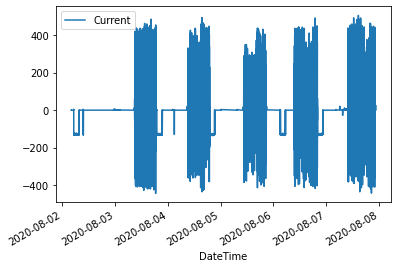

In [773]:
# Original

c_o = current_threeToseven.plot(x="DateTime", y="Current")

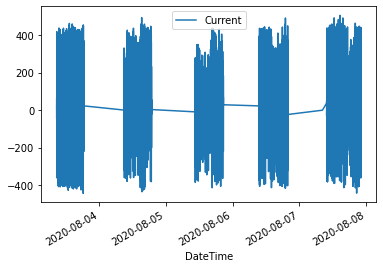

In [774]:
# Merged

c_m = august_threeToseven_i.plot(y="Current")

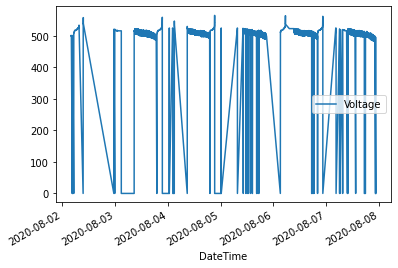

In [775]:
# Original

v_o = voltage_threeToseven.plot(x="DateTime", y="Voltage")

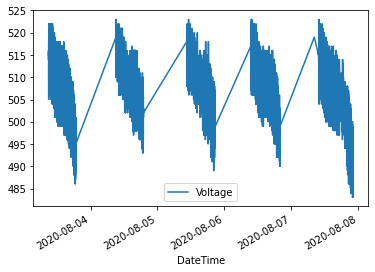

In [776]:
# Merged

v_m = august_threeToseven_i.plot(y="Voltage")

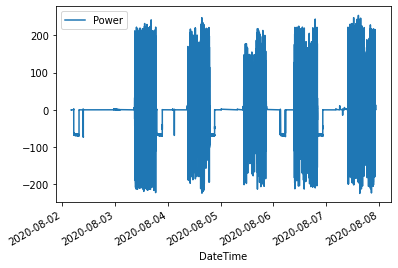

In [777]:
# Original
p_o = power_threeToseven.plot(x="DateTime", y="Power")

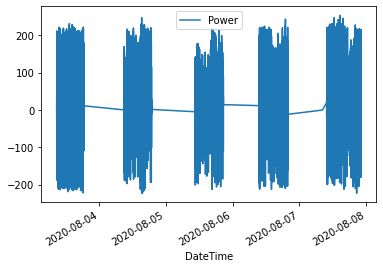

In [778]:
# Merged

p_m = august_threeToseven_i.plot(y="Power")

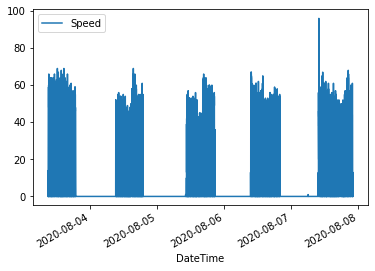

In [779]:
# Original

s_o = speed_threeToseven.plot(x="DateTime", y="Speed")

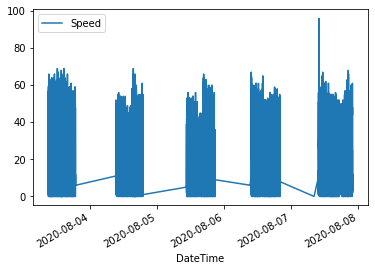

In [780]:
# Merged

s_m = august_threeToseven_i.plot(y="Speed")

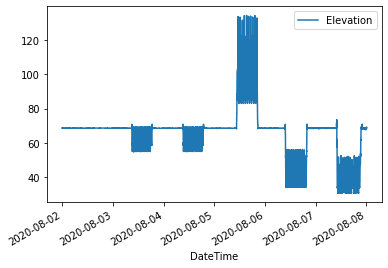

In [781]:
# Original

e_o = elev_threeToseven.plot(x="DateTime", y="Elevation")

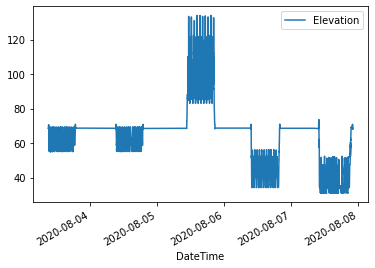

In [782]:
# Merged

e_m = august_threeToseven_i.plot(y="Elevation")

In [783]:
# To confirm suspicion of gap in data collection from sensor.
# Downsampled data shows gap due to gap in the original dataset.
# In other words, nothing to downsample from (for by hour in this case) the original hence the NaNs in the downsampled dataset.

sample = august_threeToseven_i_byHour.loc['2020-08-03':'2020-08-04']

In [784]:
sample

,Current,Voltage,Power,Elevation,Speed,Odometer,Temperature,Acceleration,Grade,Angle,DayofWeek
DateTime,,,,,,,,,,,
2020-08-03 08:00:00,46.814035,513.736842,23.636365,68.580702,15.175439,137084.601754,75.947368,0.057994,0.487680,0.330694,Monday
2020-08-03 09:00:00,38.521206,513.417879,18.948626,63.489744,29.519058,137095.878032,79.410949,-0.066516,-0.152886,0.066516,Monday
2020-08-03 10:00:00,33.854192,512.556138,16.615241,63.251722,25.998503,137110.539746,81.327844,-0.083076,-0.231840,-0.066298,Monday
2020-08-03 11:00:00,37.017060,509.346535,18.024716,62.597563,28.464585,137124.246154,80.350343,-0.088393,0.156416,0.324286,Monday
2020-08-03 12:00:00,35.304762,508.163383,17.112039,63.032594,28.745484,137137.967898,79.414614,-0.099657,-0.274070,-0.091701,Monday
2020-08-03 13:00:00,41.483814,507.389866,20.223666,62.560873,27.647431,137151.611541,79.000000,-0.110108,0.224020,0.320698,Monday
2020-08-03 14:00:00,36.016556,507.019956,17.484994,63.096009,26.174427,137165.116704,79.000000,-0.110436,-0.269296,-0.189064,Monday
2020-08-03 15:00:00,33.526890,505.594151,16.305594,63.116334,25.773181,137179.383524,78.312411,-0.131114,0.026654,0.229223,Monday
2020-08-03 16:00:00,31.784441,503.152972,15.395052,62.983916,25.363636,137192.911976,78.000000,-0.119236,-0.264995,-0.098267,Monday


In [785]:

pandas_bokeh.output_notebook()

In [786]:
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.models import LinearAxis, Range1d

p = figure(x_axis_type='datetime', plot_width=800, plot_height=500, title="Oringinal Current")

p.extra_y_ranges = {"power": Range1d(start=450, end=550)}
p.line(august_threeToseven_i.index, august_threeToseven_i.Current, line_color='navy', line_width=1)

p.line(august_threeToseven_i.index, august_threeToseven_i.Voltage, color="orange", y_range_name="power", alpha=.5)
p.add_layout(LinearAxis(y_range_name="power"), 'left')

show(p)

# **GPS dataset ouput in chunks for upload to get elevation data.**

In [787]:
# To subdivide the GPS dataset into 7 chunks for export for further processing.

"""
gps1 = gps['GPS'].iloc[:100000]
gps2 = gps['GPS'].iloc[100000:200000]
gps3 = gps['GPS'].iloc[200000:300000]
gps4 = gps['GPS'].iloc[300000:400000]
gps5 = gps['GPS'].iloc[400000:500000]
gps6 = gps['GPS'].iloc[500000:600000]
gps7 = gps['GPS'].iloc[600000:624302]
"""


"\ngps1 = gps['GPS'].iloc[:100000]\ngps2 = gps['GPS'].iloc[100000:200000]\ngps3 = gps['GPS'].iloc[200000:300000]\ngps4 = gps['GPS'].iloc[300000:400000]\ngps5 = gps['GPS'].iloc[400000:500000]\ngps6 = gps['GPS'].iloc[500000:600000]\ngps7 = gps['GPS'].iloc[600000:624302]\n"

In [788]:
# Export GPS dataset without index or header info. (For use at GPSvisualizer.com)

"""
gps1.to_csv('gps1.csv', index=False, header=False)
gps2.to_csv('gps2.csv', index=False, header=False)
gps3.to_csv('gps3.csv', index=False, header=False)
gps4.to_csv('gps4.csv', index=False, header=False)
gps5.to_csv('gps5.csv', index=False, header=False)
gps6.to_csv('gps6.csv', index=False, header=False)
gps7.to_csv('gps7.csv', index=False, header=False)
"""


"\ngps1.to_csv('gps1.csv', index=False, header=False)\ngps2.to_csv('gps2.csv', index=False, header=False)\ngps3.to_csv('gps3.csv', index=False, header=False)\ngps4.to_csv('gps4.csv', index=False, header=False)\ngps5.to_csv('gps5.csv', index=False, header=False)\ngps6.to_csv('gps6.csv', index=False, header=False)\ngps7.to_csv('gps7.csv', index=False, header=False)\n"